## **Notebook**

Niko leger med CCA her (for at prøve at forstå det)

In [2]:
# imports
from sklearn.cross_decomposition import CCA
import numpy as np
import pandas as pd
import os 
import seaborn as sns


# data load
data_path = ""
save_path = 'figures'

agg_df = pd.read_csv(os.path.join(data_path, 'HR_data.csv'), index_col=0)

count of NaNs: 9


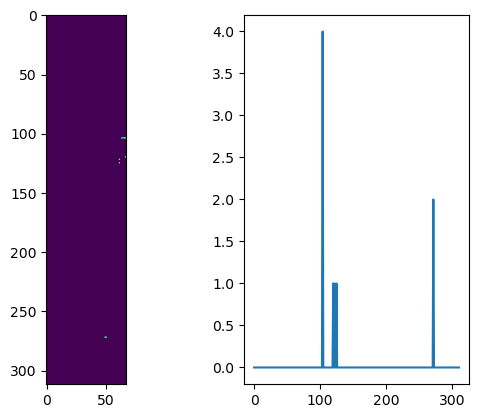

In [3]:
# inspecting NaNs
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)

axs[0].imshow(agg_df.isna())

nans = agg_df.isna()
print("count of NaNs:", np.sum(nans.values!=0))
axs[1].plot(np.sum(nans, axis=1))
plt.show()

In [4]:
# removing nan-rows
index = np.sum(nans.values, axis=1) == 0

df_removed_rows = agg_df.iloc[index]



In [5]:
# one-hot encode Cohort, but labelencode Phase and Round
#   (and drop the original Cohort column)

from sklearn.preprocessing import LabelEncoder,  OneHotEncoder

le = LabelEncoder()
ohe = OneHotEncoder()

df_ = df_removed_rows.copy()

df_['Phase'] = le.fit_transform(df_removed_rows['Phase'])
df_['Round'] = le.fit_transform(df_removed_rows['Round'])
temp = (ohe.fit_transform(np.array(df_['Cohort']).reshape(-1,1))).toarray()
new_variables = ['D1_' + str(i+1) for i in range(5)]
for i, var in enumerate(new_variables):
    df_[var] = temp[:,i]

df_ = df_.drop(columns='Cohort')

In [6]:
# defining X and Y
y_columns = ['Frustrated', 'upset', 'hostile', 'alert',
       'ashamed', 'inspired', 'nervous', 'attentive', 'afraid', 'active',
       'determined']

X_columns = ['HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std', 'HR_TD_Min', 'HR_TD_Max',
       'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew', 'HR_TD_Slope_min',
       'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope', 'TEMP_TD_Mean',
       'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min', 'TEMP_TD_Max',
       'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew', 'TEMP_TD_Slope_min',
       'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean', 'TEMP_TD_Slope',
       'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std', 'EDA_TD_P_Min',
       'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis', 'EDA_TD_P_Skew',
       'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max', 'EDA_TD_P_Slope_mean',
       'EDA_TD_P_Slope', 'EDA_TD_T_Mean', 'EDA_TD_T_Median', 'EDA_TD_T_std',
       'EDA_TD_T_Min', 'EDA_TD_T_Max', 'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis',
       'EDA_TD_T_Skew', 'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max',
       'EDA_TD_T_Slope_mean', 'EDA_TD_T_Slope', 'EDA_TD_P_Peaks',
       'EDA_TD_P_RT', 'EDA_TD_P_ReT', 'Round', 'Phase', 'Individual',
       'Puzzler'] + ['D1_' + str(i+1) for i in range(5)]

In [7]:
X = df_[X_columns]
Y = df_[y_columns]

In [8]:
import scienceplots
import matplotlib.pyplot as plt
plt.style.use('science')
plt.rcParams.update({'figure.dpi': '200'})
plt.rcParams.update({"legend.frameon": True})

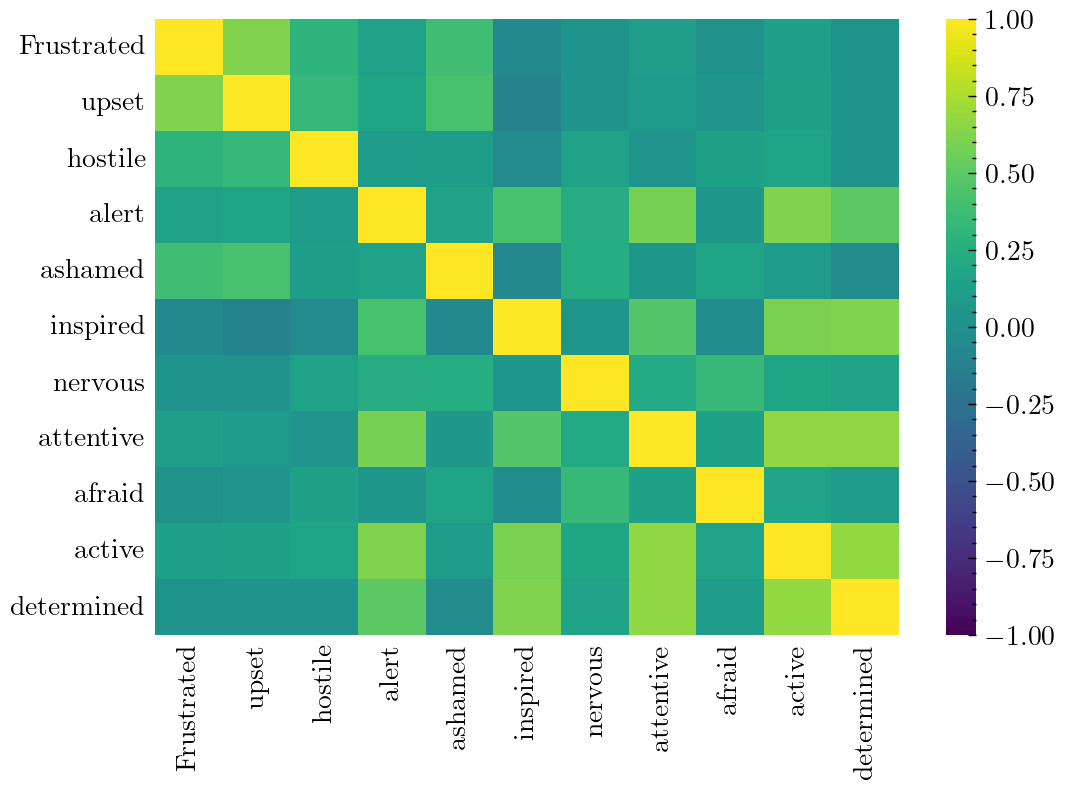

In [9]:
plt.figure(figsize=(6,4))
axs = sns.heatmap(Y.corr(), 
                    #annot=True, 
                    #fmt=".2f", 
                    #linewidths=.5, 
                    cmap=sns.color_palette("viridis", as_cmap=True),
                    vmin=-1, 
                    vmax=1)
axs.xaxis.set_ticks_position('none')
axs.yaxis.set_ticks_position('none')
plt.savefig("figures/heatmap_Y.png", dpi=200)
plt.show()

In [10]:
cca = CCA(n_components=2, scale=True, max_iter=500)

cca.fit(X, Y)

CCA()

In [251]:
X.shape, Y.shape

((307, 60), (307, 11))

In [252]:
cca.x_weights_.shape, cca.y_weights_.shape

((60, 2), (11, 2))

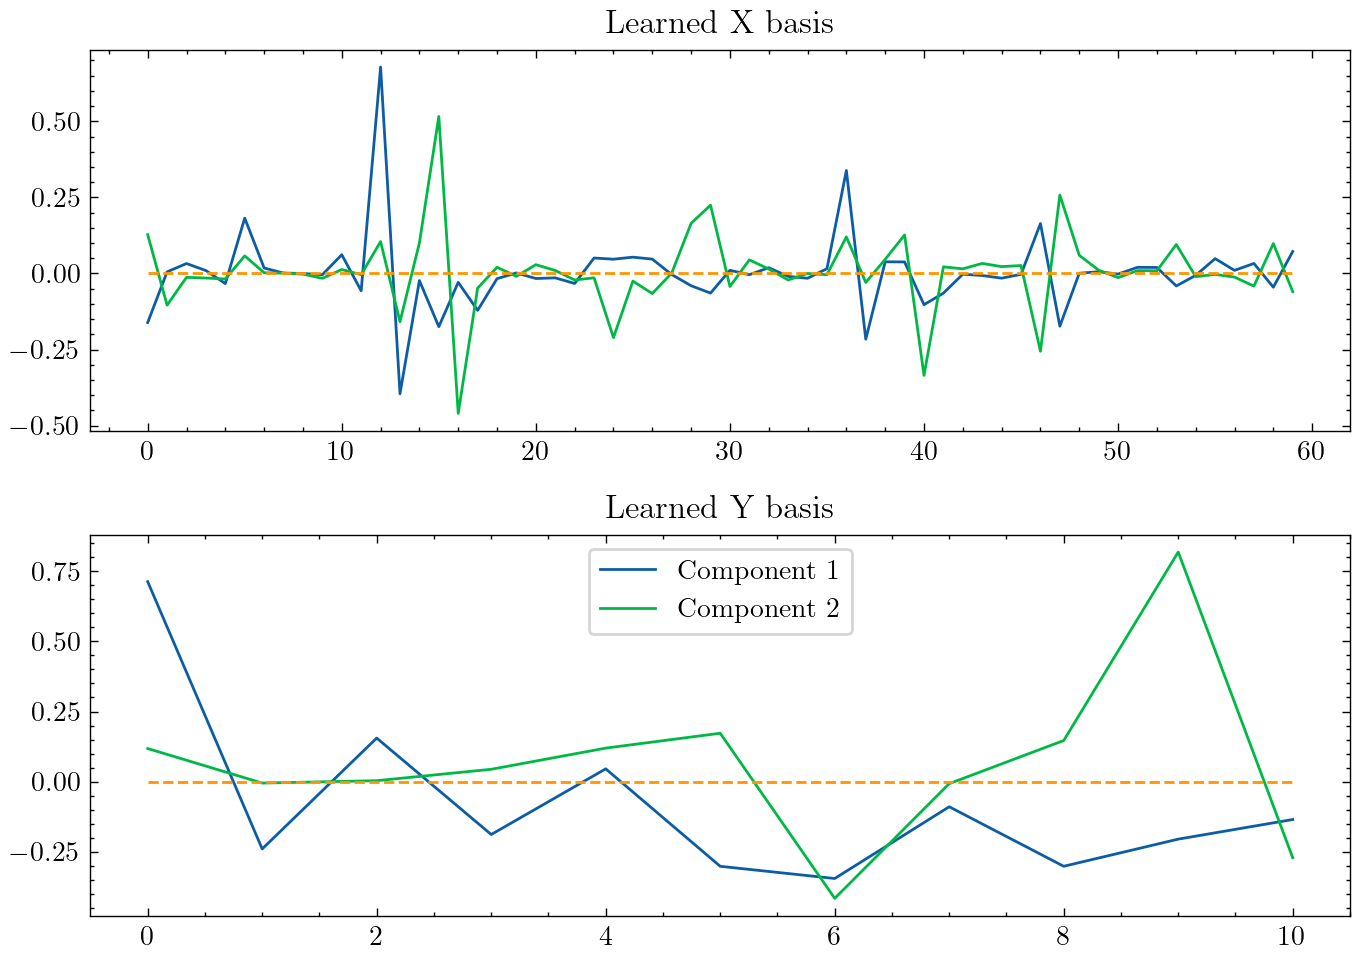

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(7,5))



axs[0].plot(cca.x_weights_[:,0], label='Component 1')
axs[0].plot(cca.x_weights_[:,1], label='Component 2')
axs[0].plot(np.zeros(len(cca.x_weights_[:,0])), '--')
axs[0].set_title('Learned X basis')
axs[1].plot(cca.y_weights_[:,0], label='Component 1')
axs[1].plot(cca.y_weights_[:,1], label='Component 2')
axs[1].plot(np.zeros(len(cca.y_weights_[:,0])), '--')
axs[1].set_title('Learned Y basis')
plt.legend()
plt.tight_layout()
plt.savefig("figures/basis.png", dpi=200)
plt.show()


In [15]:
# five largest features in X that (in absolute value)
x_index = np.argsort(np.abs(cca.x_weights_[:,0]))[:5]
y_index = np.argsort(np.abs(cca.y_weights_[:,0]))[:5]
X.columns[x_index], Y.columns[y_index]



(Index(['HR_TD_Slope_min', 'EDA_TD_P_Peaks', 'HR_TD_Skew', 'TEMP_TD_Skew',
        'EDA_TD_P_ReT'],
       dtype='object'),
 Index(['ashamed', 'attentive', 'determined', 'hostile', 'alert'], dtype='object'))

In [17]:
X_trans, Y_trans = cca.transform(X, Y)

In [256]:
X_trans.shape, Y_trans.shape

((307, 2), (307, 2))

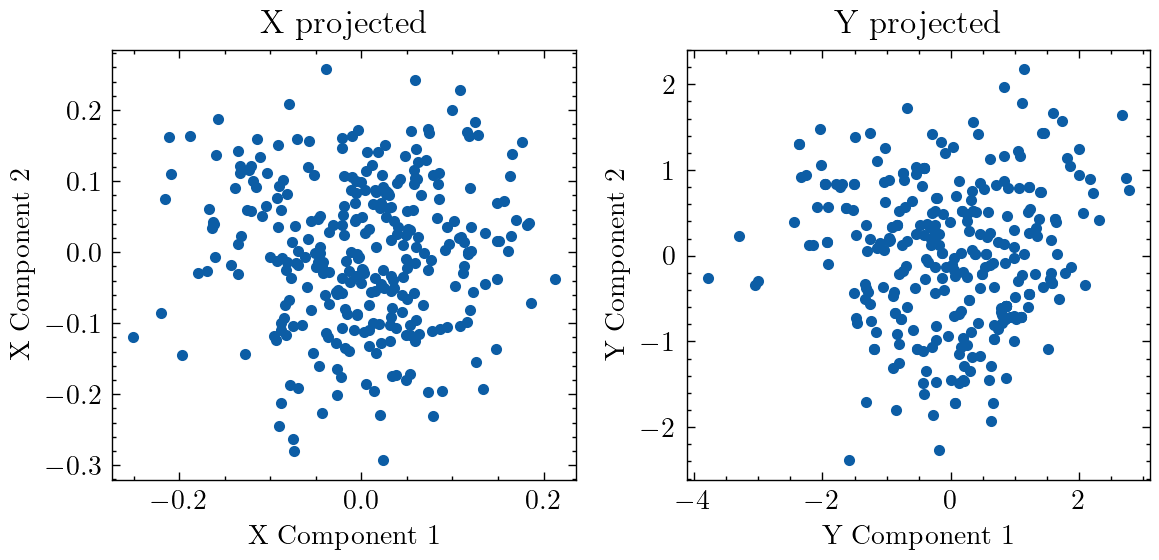

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(6,3))

axs[0].plot(X_trans[:,0], X_trans[:,1], '.')
axs[0].set_title('X projected')
axs[0].set_xlabel('X Component 1')
axs[0].set_ylabel('X Component 2')
axs[1].plot(Y_trans[:, 0], Y_trans[:, 1], '.')
axs[1].set_title('Y projected')
axs[1].set_xlabel('Y Component 1')
axs[1].set_ylabel('Y Component 2')
plt.savefig("figures/projected1.png", dpi=200)
plt.tight_layout()
plt.show()

The X data is projected onto the x-basis, and the data becomes uncorrelated. Same for Y. 

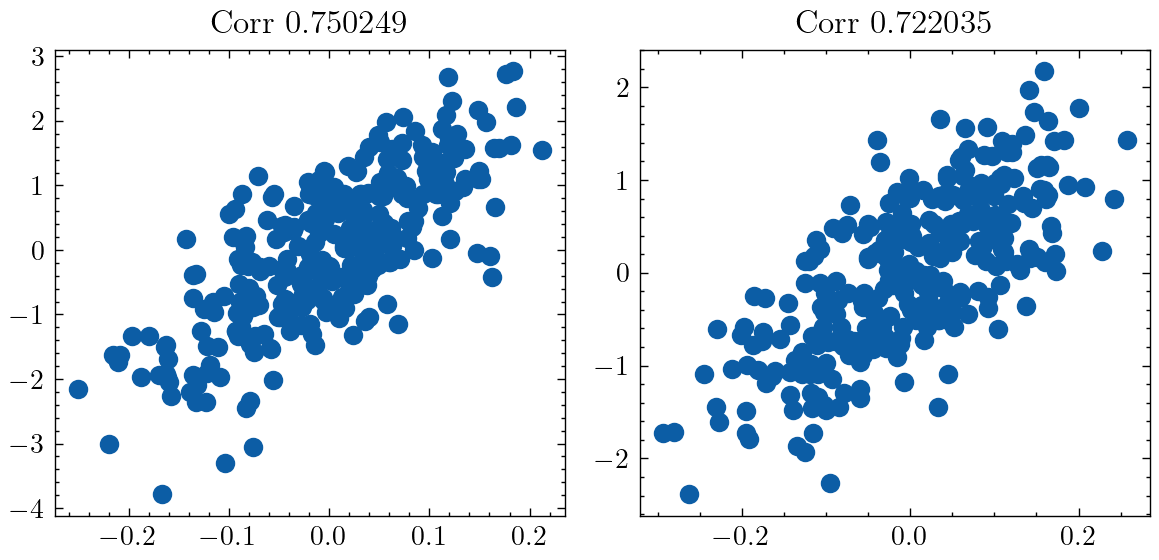

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(6,3))

axs[0].plot(X_trans[:,0], Y_trans[:,0], 'o')
axs[0].set_title(f"Corr {np.corrcoef(X_trans[:,0], Y_trans[:,0])[0,1]:2f}")
axs[1].plot(X_trans[:, 1], Y_trans[:, 1], 'o')
axs[1].set_title(f"Corr {np.corrcoef(X_trans[:,1], Y_trans[:,1])[0,1]:2f}")
plt.savefig("figures/projected2.png", dpi=200)
plt.tight_layout()
plt.show()

Conclusion: The CCA has learned some components where the projections are very correlated.

The first X basis is highly correlated with the first Y basis and same for second basis pair.